# Installing Packages

In [ ]:
%pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

# Importing Packages

In [1]:
import pandas as pd
import numpy as np

from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, DDPG, PPO
from finrl.plot import backtest_stats, backtest_plot, get_baseline, get_daily_return

import ctypes
import gymnasium as gym
from gymnasium import spaces

import itertools
import matplotlib.pyplot as plt
%matplotlib inline

/home/shlok/MTP/.venv/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# Creating Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Global Vars

In [2]:
TICKER_LIST = ['AAPL', 'JPM', 'JNJ', 'TSLA', 'NVDA', 'AMD', 'META', 'AMZN']
INIT_TRADING_AMOUNT = 1000

# Downloading Market Data

In [3]:
df = YahooDownloader(start_date=config.TRAIN_START_DATE,
                     end_date=config.TRADE_END_DATE,
                     ticker_list=TICKER_LIST).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (15928, 8)


In [4]:
df

Price,date,close,high,low,open,volume,tic,day
0,2014-01-06,16.871344,16.960363,16.550933,16.670351,412610800,AAPL,0
1,2014-01-06,4.130000,4.180000,3.990000,4.010000,42398300,AMD,0
2,2014-01-06,19.681499,19.850000,19.421000,19.792500,63412000,AMZN,0
3,2014-01-06,66.566399,66.869201,66.234757,66.278013,7443500,JNJ,0
4,2014-01-06,42.963310,43.305561,42.839519,43.079821,17550700,JPM,0
...,...,...,...,...,...,...,...,...
15923,2021-11-30,139.573074,142.321041,139.501478,141.882436,14981700,JNJ,1
15924,2021-11-30,142.999313,144.619909,142.513128,143.296424,18922600,JPM,1
15925,2021-11-30,322.472046,333.752511,321.448358,332.947476,25390000,META,1
15926,2021-11-30,32.610649,33.286297,31.800275,33.102663,622066000,NVDA,1


# Preprocessing Data

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list=config.INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

# Data Cleaning
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,TICKER_LIST))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

print("Data Processing Complete.")
processed_full.tail()

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (1990, 8)
Successfully added vix
Successfully added turbulence index
Data Processing Complete.


,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2014-01-06,AAPL,16.871347,16.960367,16.550936,16.670354,412610800.0,0.0,0.0,16.981654,16.640384,0.0,-66.666667,100.0,16.871347,16.871347,13.55,0.0
5,2014-01-06,AMD,4.130000,4.180000,3.990000,4.010000,42398300.0,0.0,0.0,16.981654,16.640384,0.0,-66.666667,100.0,4.130000,4.130000,13.55,0.0
7,2014-01-06,AMZN,19.681499,19.850000,19.421000,19.792500,63412000.0,0.0,0.0,16.981654,16.640384,0.0,-66.666667,100.0,19.681499,19.681499,13.55,0.0
2,2014-01-06,JNJ,66.566376,66.869178,66.234734,66.277990,7443500.0,0.0,0.0,16.981654,16.640384,0.0,-66.666667,100.0,66.566376,66.566376,13.55,0.0
1,2014-01-06,JPM,42.963318,43.305569,42.839527,43.079828,17550700.0,0.0,0.0,16.981654,16.640384,0.0,-66.666667,100.0,42.963318,42.963318,13.55,0.0


# Splitting and Saving the Data

In [ ]:
train = data_split(processed_full, config.TRAIN_START_DATE,config.TRAIN_END_DATE)
trade = data_split(processed_full, config.TEST_START_DATE,config.TEST_END_DATE)
print(len(train))
print(len(trade))
train.to_csv("./" + config.DATA_SAVE_DIR + "/train_data.csv", index=False)
trade.to_csv("./" + config.DATA_SAVE_DIR + "/trade_data.csv", index=False)

13232
2352


# Trading Wrapper

In [13]:
class InputsTradingEnforcer(ctypes.Structure):
    _fields_ = [
        ("dd_exceeded", ctypes.c_bool),
        ("is_illiquid", ctypes.c_bool),
        ("will_exceed_limit", ctypes.c_bool),
        ("price_deviates", ctypes.c_bool),
    ]

class OutputsTradingEnforcer(ctypes.Structure):
    _fields_ = [
        ("act_TRADE", ctypes.c_bool),
        ("act_BUY", ctypes.c_bool),
    ]

class EnforcerVarsTradingEnforcer(ctypes.Structure):
    _fields_ = [
        ("_policy_state", ctypes.c_int),
        ("t_window", ctypes.c_uint64),
    ]

lib_path = "../policies/TradingEnforcer/libtradingenforcer.so"
lib = ctypes.CDLL(lib_path)

lib.TradingEnforcer_init_all_vars.argtypes = [ctypes.POINTER(EnforcerVarsTradingEnforcer), ctypes.POINTER(InputsTradingEnforcer), ctypes.POINTER(OutputsTradingEnforcer)]
lib.TradingEnforcer_run_via_enforcer.argtypes = [ctypes.POINTER(EnforcerVarsTradingEnforcer), ctypes.POINTER(InputsTradingEnforcer), ctypes.POINTER(OutputsTradingEnforcer)]

class RuntimeEnforcementWrapper(gym.Wrapper):
    def __init__(self, 
                 env, log_file="./enforcement_log.txt", 
                 drawdown_limit=0.10, 
                 concentration_limit=0.20, 
                 min_volume_limit=100000,
                 logging_enabled=True):
        super().__init__(env)
        
        self.log_file = log_file
        self.drawdown_limit = drawdown_limit
        self.concentration_limit = concentration_limit
        self.min_volume_limit = min_volume_limit
        
        self.log_handle = open(self.log_file_path, "w")
        self.log_handle.write("RuntimeEnforcementWrapper initialized.\n")
        self.log_handle.write(f"Settings: DD={drawdown_limit}, Conc={concentration_limit}, Vol={min_volume_limit}\n")
             
        self.stock_dim = env.action_space.shape[0]
        
        self.enforcers = []
        self.inputs_structs = []
        self.outputs_structs = []
        
        for _ in range(self.stock_dim):
            enf = EnforcerVarsTradingEnforcer()
            inp = InputsTradingEnforcer()
            out = OutputsTradingEnforcer()
            
            lib.TradingEnforcer_init_all_vars(ctypes.byref(enf), ctypes.byref(inp), ctypes.byref(out))
            
            self.enforcers.append(enf)
            self.inputs_structs.append(inp)
            self.outputs_structs.append(out)
    
    def _log(self, msg):
        if self.logging_enabled:
            self.log_handle.write(msg + "\n")

    def close(self):
        if hasattr(self, 'log_handle') and not self.log_handle.closed:
            self.log_handle.write("--- End of Logs ---\n")
            self.log_handle.close()
        return super().close()

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

    def step(self, action):
        # Access the underlying FinRL environment to get internal state
        base_env = self.env.unwrapped
        
        # 1. Calculate Current Drawdown
        asset_memory = base_env.asset_memory
        if len(asset_memory) > 0:
            peak_value = max(asset_memory)
            current_value = asset_memory[-1]
            current_drawdown = (peak_value - current_value) / peak_value if peak_value > 0 else 0.0
        else:
            current_drawdown = 0.0

        # 2. Extract State Information
        state = base_env.state
        stock_dim = self.stock_dim
        
        idx_cash = 0
        idx_prices_start = 1
        idx_prices_end = 1 + stock_dim
        idx_shares_start = idx_prices_end
        idx_shares_end = idx_shares_start + stock_dim
        
        current_cash = state[idx_cash]
        current_prices = np.array(state[idx_prices_start:idx_prices_end])
        current_shares = np.array(state[idx_shares_start:idx_shares_end])
        
        # Calculate total portfolio value
        portfolio_value = current_cash + np.sum(current_prices * current_shares)

        # 3. Extract Liquidity (Volume)
        current_volumes = base_env.data['volume'].values

        # --- LOGGING HEADER ---
        self._log(f"\n=== Step {base_env.day} ===")
        self._log(f"Portfolio Value: {portfolio_value:,.2f}")
        self._log(f"Current Drawdown: {current_drawdown:.2%} (Limit: {self.drawdown_limit:.0%})")

        safe_action = np.copy(action)
        
        for i in range(self.stock_dim):
            ticker = TICKER_LIST[i] if 'TICKER_LIST' in globals() else f"Stock_{i}"
            
            # A. Populate Inputs for the Enforcer
            self.inputs_structs[i].dd_exceeded = bool(current_drawdown > self.drawdown_limit)
            self.inputs_structs[i].is_illiquid = bool(current_volumes[i] < self.min_volume_limit)
            
            # Concentration Check
            proposed_shares = current_shares[i] + action[i]
            if proposed_shares < 0: proposed_shares = 0
            
            proposed_position_value = proposed_shares * current_prices[i]
            
            projected_concentration = 0.0
            if portfolio_value > 0:
                projected_concentration = proposed_position_value / portfolio_value
                self.inputs_structs[i].will_exceed_limit = bool(projected_concentration > self.concentration_limit)
            else:
                self.inputs_structs[i].will_exceed_limit = False

            self.inputs_structs[i].price_deviates = False 
            
            # B. Populate Proposed Outputs from RL Action
            self.outputs_structs[i].act_TRADE = (abs(action[i]) > 0)
            self.outputs_structs[i].act_BUY = (action[i] > 0)
            
            # --- LOGGING PRE-ENFORCEMENT ---
            if abs(action[i]) > 0: # Only log active trades to reduce noise
                self._log(f"[{ticker}] Agent Action: {'BUY' if action[i]>0 else 'SELL'} {abs(action[i]):.0f} shares @ {current_prices[i]:.2f}")
                self._log(f"    > Liquidity: {current_volumes[i]:,.0f} (Min: {self.min_volume_limit}) -> Illiquid: {self.inputs_structs[i].is_illiquid}")
                self._log(f"    > Concentration: {projected_concentration:.2%} (Limit: {self.concentration_limit:.0%}) -> Exceeds: {self.inputs_structs[i].will_exceed_limit}")

            # C. Run the Enforcer
            lib.TradingEnforcer_run_via_enforcer(
                ctypes.byref(self.enforcers[i]),
                ctypes.byref(self.inputs_structs[i]),
                ctypes.byref(self.outputs_structs[i])
            )
            
            # D. Apply Enforced Outputs to Action
            original_action_val = safe_action[i]
            
            if not self.outputs_structs[i].act_TRADE:
                safe_action[i] = 0
            elif not self.outputs_structs[i].act_BUY and safe_action[i] > 0:
                    safe_action[i] = 0 
            
            # --- LOGGING POST-ENFORCEMENT ---
            if safe_action[i] != original_action_val:
                self._log(f"    *** ENFORCER BLOCKED ***")
                self._log(f"    Reason: DD={self.inputs_structs[i].dd_exceeded}, Illiq={self.inputs_structs[i].is_illiquid}, Conc={self.inputs_structs[i].will_exceed_limit}")
                self._log(f"    Final Action: 0")
            elif abs(action[i]) > 0:
                self._log(f"    > Enforcer Allowed.")

        # 2. Step the environment with the SAFE action
        return self.env.step(safe_action)
    
    def __getattr__(self, name):
        """Delegate attribute access to the underlying environment."""
        return getattr(self.env, name)

# Setting Up Training Environment

In [6]:
stock_dimension = len(TICKER_LIST)
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs_train = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

train = pd.read_csv("./" + config.DATA_SAVE_DIR + "/train_data.csv")
train = train.set_index(train.columns[0])
train.index.names = ['']

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train, **env_kwargs_train)
env_train, _ = e_train_gym.get_sb_env()

Stock Dimension: 8, State Space: 81


# DRL Models

In [7]:
agent = DRLAgent(env = env_train)

model_a2c = agent.get_model("a2c", model_kwargs=config.A2C_PARAMS)
model_ddpg = agent.get_model("ddpg", model_kwargs=config.DDPG_PARAMS)
model_ppo = agent.get_model("ppo", model_kwargs=config.PPO_PARAMS)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device


# Training the Models

In [80]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=50000)
trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg', total_timesteps=50000)
trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=50000)

---------------------------------------
| time/                 |             |
|    fps                | 500         |
|    iterations         | 100         |
|    time_elapsed       | 0           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -11.5       |
|    explained_variance | -0.0849     |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -8.09       |
|    reward             | -1.3309691  |
|    reward_max         | 1.7666025   |
|    reward_mean        | 0.088911265 |
|    reward_min         | -1.3309691  |
|    std                | 1.02        |
|    value_loss         | 3.36        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 516         |
|    iterations         | 200         |
|    time_elapsed       | 1           |
|    total_timesteps    | 1000        |


# Saving the Models

In [81]:
trained_a2c.save("./" + config.TRAINED_MODEL_DIR + "/a2c_trained_model")
trained_ddpg.save("./" + config.TRAINED_MODEL_DIR + "/ddpg_trained_model")
trained_ppo.save("./" + config.TRAINED_MODEL_DIR + "/ppo_trained_model")

# Trading

In [4]:
trade = pd.read_csv("./" + config.DATA_SAVE_DIR + "/trade_data.csv")
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

stock_dimension = len(TICKER_LIST)
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs_trade = {
    "hmax": 100,
    "initial_amount": INIT_TRADING_AMOUNT,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

Stock Dimension: 8, State Space: 81


## A2C

In [ ]:
# Without Enforcement
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs_trade)
trained_a2c = A2C.load("./" + config.TRAINED_MODEL_DIR + "/a2c_trained_model")
df_account_value_a2c_vanilla, df_actions_a2c_vanilla = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym
    )

e_trade_gym.reset()
# With Enforcement
e_trade_gym = RuntimeEnforcementWrapper(e_trade_gym)
df_account_value_a2c_enf, df_actions_a2c_enf = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym
    )

df_account_value_a2c_vanilla.tail()

hit end!
RuntimeEnforcementWrapper initialized.

=== Step 0 ===
Portfolio Value: 1,000.00
Current Drawdown: 0.00% (Limit: 10%)
[AAPL] Agent Action: BUY 0 shares @ 105.67
    > Liquidity: 308,151,200 (Min: 100000) -> Illiquid: False
    > Concentration: 2.10% (Limit: 20%) -> Exceeds: False
    > Enforcer Allowed.
[JPM] Agent Action: BUY 1 shares @ 77.67
    > Liquidity: 42,628,800 (Min: 100000) -> Illiquid: False
    > Concentration: 6.75% (Limit: 20%) -> Exceeds: False
    > Enforcer Allowed.
[JNJ] Agent Action: SELL 1 shares @ 155.59
    > Liquidity: 101,494,000 (Min: 100000) -> Illiquid: False
    > Concentration: 0.00% (Limit: 20%) -> Exceeds: False
    > Enforcer Allowed.
[TSLA] Agent Action: BUY 1 shares @ 126.92
    > Liquidity: 4,078,700 (Min: 100000) -> Illiquid: False
    > Concentration: 12.69% (Limit: 20%) -> Exceeds: False
    > Enforcer Allowed.
[NVDA] Agent Action: BUY 1 shares @ 83.63
    > Liquidity: 12,962,800 (Min: 100000) -> Illiquid: False
    > Concentration: 5.45%

,date,account_value
289,2021-09-24,1663.223451
290,2021-09-27,1671.344972
291,2021-09-28,1615.342012
292,2021-09-29,1612.457368
293,2021-09-30,1609.639650


In [12]:
# df_actions_a2c.head()
# df_account_value_a2c.tail()
df_account_value_a2c_enf.tail()

,date,account_value
289,2021-09-24,1910.546114
290,2021-09-27,1934.519320
291,2021-09-28,1871.988085
292,2021-09-29,1868.586535
293,2021-09-30,1863.587461


## DDPG

In [85]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs_trade)
trained_ddpg = DDPG.load("./" + config.TRAINED_MODEL_DIR + "/ddpg_trained_model")
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

df_account_value_ddpg.tail()

hit end!


,date,account_value
289,2021-09-24,2590.310049
290,2021-09-27,2646.876821
291,2021-09-28,2600.876760
292,2021-09-29,2613.376760
293,2021-09-30,2593.943472


In [86]:
df_actions_ddpg.head()

,AAPL,AMD,AMZN,JNJ,JPM,META,NVDA,TSLA
date,,,,,,,,
2020-08-03,0,0,0,0,0,0,0,10
2020-08-04,0,0,0,0,0,0,0,0
2020-08-05,0,0,0,0,0,0,0,0
2020-08-06,0,0,0,0,0,0,0,0
2020-08-07,0,0,0,0,0,0,0,0


## PPO

In [87]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs_trade)
trained_ppo = PPO.load("./" + config.TRAINED_MODEL_DIR + "/ppo_trained_model")
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

df_account_value_ppo.tail()

hit end!


,date,account_value
289,2021-09-24,1193.634551
290,2021-09-27,1185.169097
291,2021-09-28,1182.607329
292,2021-09-29,1191.215728
293,2021-09-30,1173.287871


In [88]:
df_actions_ppo.head()

,AAPL,AMD,AMZN,JNJ,JPM,META,NVDA,TSLA
date,,,,,,,,
2020-08-03,0,0,6,0,0,0,0,0
2020-08-04,0,0,0,0,0,0,0,0
2020-08-05,0,0,0,0,0,0,0,0
2020-08-06,0,0,0,0,0,0,0,0
2020-08-07,0,0,0,0,0,0,0,0


# Trading Stats

## A2C

In [89]:
perf_stats_a2c = backtest_stats(df_account_value_a2c)
perf_stats_a2c = pd.DataFrame(perf_stats_a2c)

Annual return          0.503820
Cumulative returns     0.609640
Annual volatility      0.320329
Sharpe ratio           1.438759
Calmar ratio           2.928561
Stability              0.941550
Max drawdown          -0.172037
Omega ratio            1.276002
Sortino ratio          2.157419
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.089954
Daily value at risk   -0.038529
dtype: float64


## DDPG

In [90]:
perf_stats_ddpg = backtest_stats(df_account_value_ddpg)
perf_stats_ddpg = pd.DataFrame(perf_stats_ddpg)

Annual return          1.263723
Cumulative returns     1.593943
Annual volatility      0.631337
Sharpe ratio           1.614579
Calmar ratio           3.497132
Stability              0.498468
Max drawdown          -0.361360
Omega ratio            1.336048
Sortino ratio          2.543911
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.194977
Daily value at risk   -0.075496
dtype: float64


## PPO

In [91]:
perf_stats_ppo = backtest_stats(df_account_value_ppo)
perf_stats_ppo = pd.DataFrame(perf_stats_ppo)

Annual return          0.146805
Cumulative returns     0.173288
Annual volatility      0.219418
Sharpe ratio           0.736538
Calmar ratio           0.822815
Stability              0.793539
Max drawdown          -0.178418
Omega ratio            1.146182
Sortino ratio          1.031672
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.991267
Daily value at risk   -0.027003
dtype: float64


## Overall Stats

### Getting the Baseline

In [92]:
baseline_dji = get_baseline(ticker="^DJI",
                            start=config.TEST_START_DATE,
                            end=config.TEST_END_DATE)

baseline_dji = baseline_dji[['date', 'close']]
init_val = baseline_dji['close'][0]
df_account_value_dji = pd.merge(baseline_dji['date'], 
                                baseline_dji['close'].div(init_val).mul(INIT_TRADING_AMOUNT),
                                how='outer', left_index=True, right_index=True)
df_account_value_dji.columns = ['date','account_value']
perf_stats_dji = backtest_stats(df_account_value_dji)
perf_stats_dji = pd.DataFrame(perf_stats_dji)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (294, 8)
Annual return          0.226750
Cumulative returns     0.269255
Annual volatility      0.139601
Sharpe ratio           1.539212
Calmar ratio           2.538976
Stability              0.915926
Max drawdown          -0.089308
Omega ratio            1.294292
Sortino ratio          2.240389
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995019
Daily value at risk   -0.016735
dtype: float64


In [93]:
perf_stats = perf_stats_a2c.merge(perf_stats_ddpg, left_index=True, right_index=True, suffixes=('a2c','ddpg'))
perf_stats = perf_stats.merge(perf_stats_ppo, left_index=True, right_index=True)
perf_stats = perf_stats.merge(perf_stats_dji, left_index=True, right_index=True)
perf_stats.columns = ['A2C', 'DDPG', 'PPO', 'DJI']
perf_stats = perf_stats.drop(['Skew', 'Kurtosis'], axis=0)
perf_stats

,A2C,DDPG,PPO,DJI
Annual return,0.503820,1.263723,0.146805,0.226750
Cumulative returns,0.609640,1.593943,0.173288,0.269255
Annual volatility,0.320329,0.631337,0.219418,0.139601
Sharpe ratio,1.438759,1.614579,0.736538,1.539212
Calmar ratio,2.928561,3.497132,0.822815,2.538976
Stability,0.941550,0.498468,0.793539,0.915926
Max drawdown,-0.172037,-0.361360,-0.178418,-0.089308
Omega ratio,1.276002,1.336048,1.146182,1.294292
Sortino ratio,2.157419,2.543911,1.031672,2.240389
Tail ratio,1.089954,1.194977,0.991267,0.995019


### Portfolio Value over Time

<Axes: xlabel='date'>

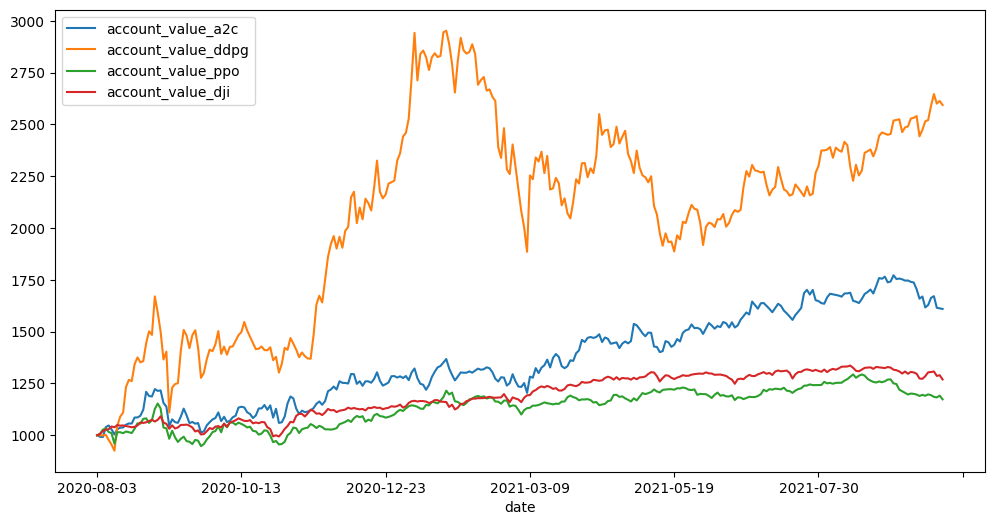

In [96]:
df_account_value = df_account_value_a2c.merge(df_account_value_ddpg, left_on='date', right_on='date', suffixes=('a2c','ddpg'))
df_account_value = df_account_value.merge(df_account_value_ppo, left_on='date', right_on='date')
df_account_value = df_account_value.merge(df_account_value_dji, left_on='date', right_on='date')

df_account_value.columns = ['date', 'account_value_a2c', 'account_value_ddpg', 'account_value_ppo', 'account_value_dji']
df_account_value.plot(x='date', y=['account_value_a2c', 'account_value_ddpg', 'account_value_ppo', 'account_value_dji'], figsize=(12,6))

## Detailed Analysis

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (294, 8)



/home/shlok/MTP/.venv/lib/python3.12/site-packages/finrl/plot.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
/home/shlok/MTP/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '71.929%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2020-08-03
End date,2021-09-30
Total months,14
,Backtest
Annual return,71.929%
Cumulative returns,88.18%
Annual volatility,41.712%
Sharpe ratio,1.51
Calmar ratio,2.95
Stability,0.78
Max drawdown,-24.369%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.37,2021-02-16,2021-03-08,2021-04-13,41
1,16.96,2020-09-02,2020-09-08,2020-11-06,48
2,15.31,2021-04-15,2021-05-13,2021-05-28,32
3,13.34,2020-11-06,2021-01-06,2021-02-10,69
4,12.26,2021-07-06,2021-07-16,2021-08-20,34


/home/shlok/MTP/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.25%,-9.27%,8.03%


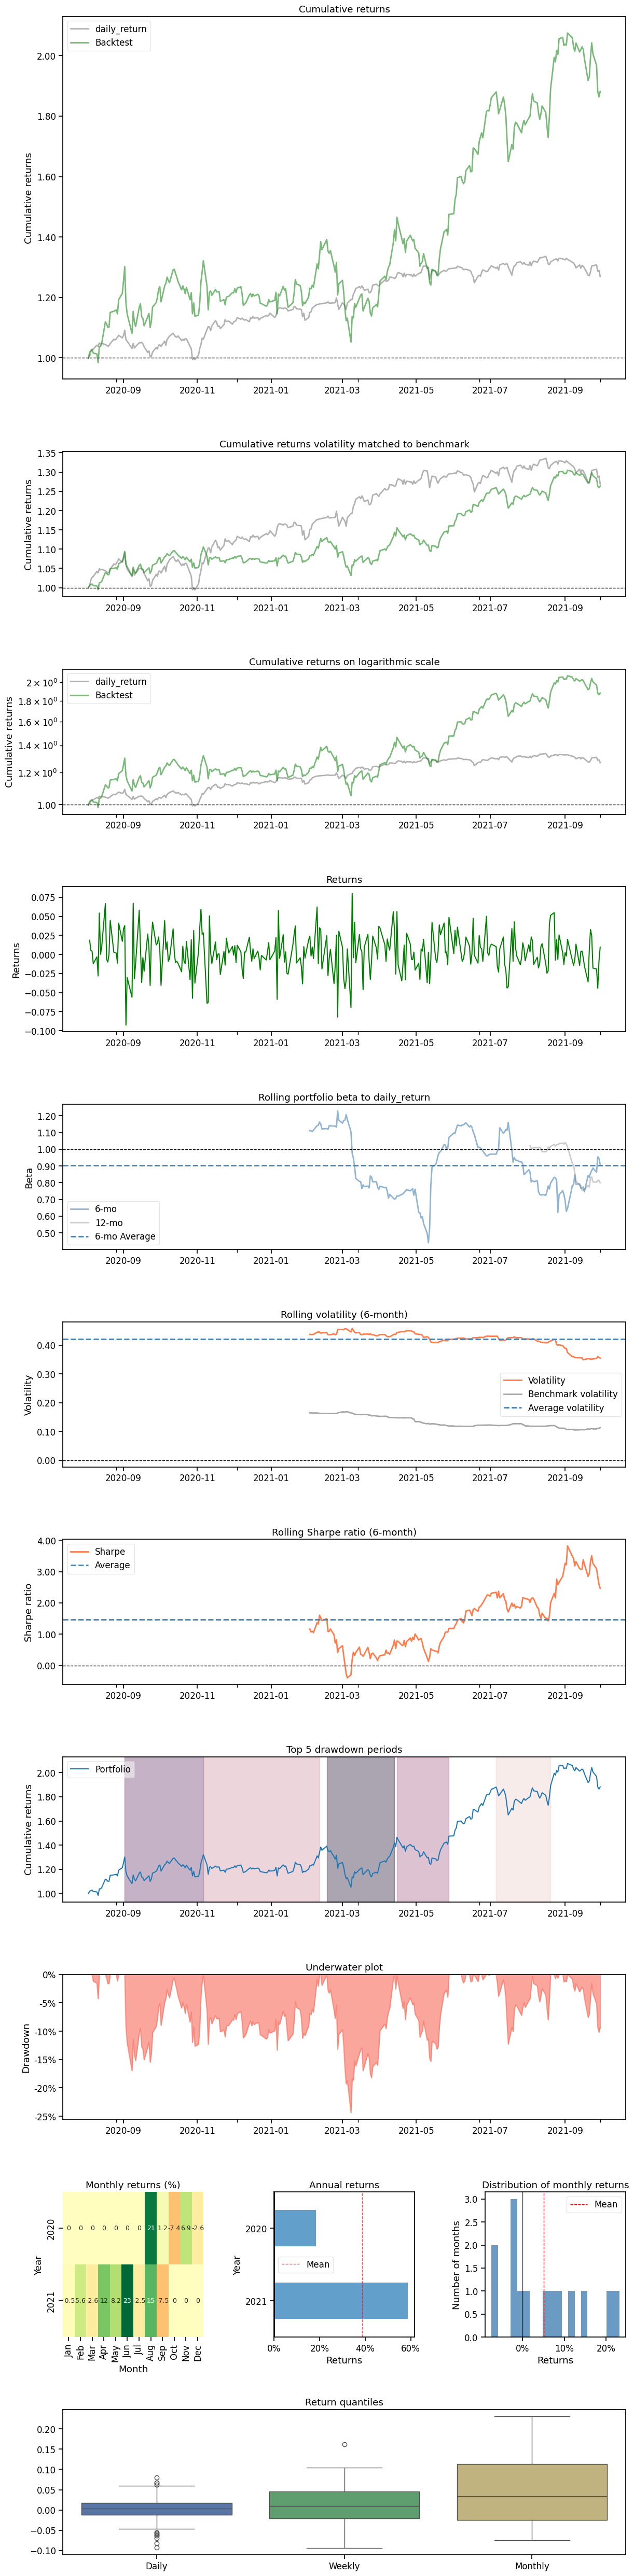

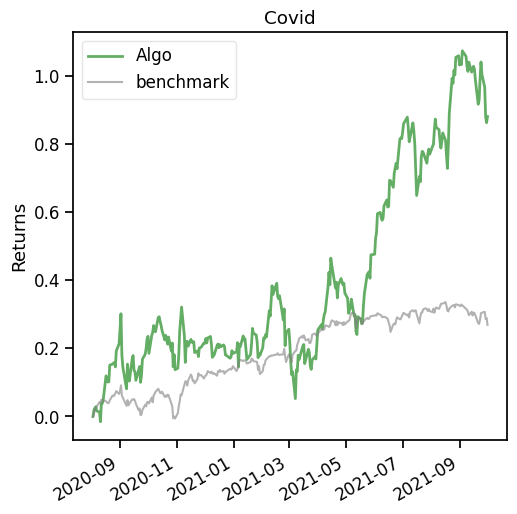

In [ ]:
backtest_plot(df_account_value_a2c,
                baseline_start=config.TEST_START_DATE,
                baseline_end=config.TEST_END_DATE)